In [1]:
import pickle
trump_data = pickle.load(open("TRUMP_SNIPPETS_DF.pickle", "rb" ))
obama_data = pickle.load(open("OBAMA_SNIPPETS_DF.pickle", "rb" ))

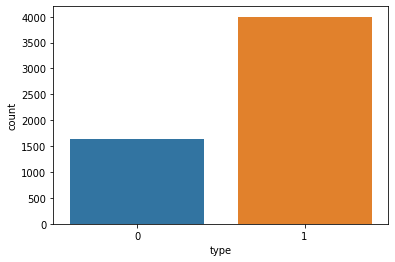

In [2]:
import seaborn as sns
sns.countplot(x='type', data=trump_data)

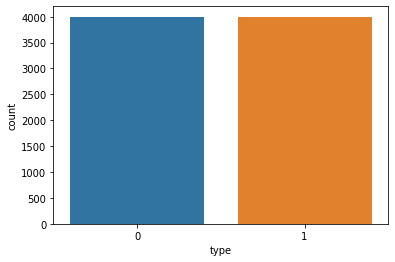

In [3]:
sns.countplot(x='type', data=obama_data)

In [4]:
import pandas as pd
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from numpy import asarray
from numpy import zeros
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
class Metrics:
    def __init__(self, df):
        self.df = pd.read_pickle(df)
        self.union_speeches = []
        self.rally_speeches = []
        
    def find_avg_word_length(self):
        average_res = []
        rally = self._get_speeches_list_from_df(self.df,1)
        union = self._get_speeches_list_from_df(self.df,0)
        self.rally_speeches.append(rally)
        self.union_speeches.append(union)
        word_count = 0
        total_characters = 0
        for speech_list in [rally, union]:
            for speech in speech_list:
                word_count += len(speech.split())
                total_characters += len(speech) - speech.count(' ')
                
            avg_word_length = total_characters / word_count
            average_res.append(round(avg_word_length,2))
            
            
        return average_res


    def _get_speeches_list_from_df(self, df, attr_val):
        df_speeches = df.loc[df['type'] == attr_val]
        speeches_list = df_speeches['transcript'].tolist()

        return speeches_list

Using TensorFlow backend.


In [5]:
trump_snippits = Metrics("TRUMP_SNIPPETS_DF.pickle")
trump_speeches = Metrics('trump_speeches_df.pickle')
obama_speeches = Metrics('obama_speeches_df.pickle')
obama_snippits = Metrics('OBAMA_SNIPPETS_DF.pickle')


print(trump_snippits.find_avg_word_length(), trump_speeches.find_avg_word_length())
print(obama_snippits.find_avg_word_length(), obama_speeches.find_avg_word_length())

[5.57, 5.77] [4.25, 4.31]
[5.67, 5.9] [4.24, 4.33]


In [6]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
from nltk.tokenize import word_tokenize

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

[nltk_data] Downloading package stopwords to /home/daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
class Compress:
    def save_as_npz(self,df,npz_name=None,tran_data='transcript',label='type'):
        X = []
        y = np.array(df[label])
        sentences = np.array(df[tran_data])
        for sen in sentences:
            X.append(preprocess_text(sen))
                        
        self._train_test_split(np.array([X]).T, np.array(y), npz_filename=npz_name)
        
        

    def _train_test_split(self,X,y,npz_filename=''+'.npz',test_size=0.2, random_state=42):
        sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
        sss.get_n_splits(np.array(X), y)
        for train_index, test_index in sss.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        tokenizer = Tokenizer(num_words=30000)
        tokenizer.fit_on_texts(X_train.ravel())
        X_train = tokenizer.texts_to_sequences(X_train.ravel())
        X_test = tokenizer.texts_to_sequences(X_test.ravel())
        
        vocab_size = len(tokenizer.word_index) + 1

        maxlen = 100

        X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
        X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
        
        embeddings_dictionary = dict()
        glove_file = open('glove.6B.50d.txt', encoding="utf8")

        for line in glove_file:
            records = line.split()
            word = records[0]
            vector_dimensions = asarray(records[1:], dtype='float32')
            embeddings_dictionary [word] = vector_dimensions
        glove_file.close()
        embedding_matrix = zeros((vocab_size, 50))
        for word, index in tokenizer.word_index.items():
            embedding_vector = embeddings_dictionary.get(word)
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
        
        np.savez_compressed(npz_filename,
                        X_train=X_train,
                        y_train=y_train,
                        X_test=X_test,
                        y_test=y_test,
                        vocab_size=vocab_size, 
                        embedding_matrix=embedding_matrix)
        print("Saved {} as .npz".format(npz_filename))
    

In [8]:
compress = Compress()
compress.save_as_npz(trump_data, npz_name='TrumpSplitData')
compress.save_as_npz(obama_data, npz_name='ObamaSplitData')

(2820, 1) (2820,) (2820, 1) (2820,)
Saved TrumpSplitData as .npz
(4000, 1) (4000,) (4000, 1) (4000,)
Saved ObamaSplitData as .npz


In [28]:
import numpy as np
class load_file:
    def __init__(self, file):
        self.file = file

    def get_data(self):
        hal = np.load(self.file)
        X_train, y_train, X_test, y_test,vocab_size, embedding_matrix = [hal[f] for f in hal.files]
        return X_train, y_train, X_test, y_test,vocab_size, embedding_matrix


df = load_file('ObamaSplitData.npz')
X_train, y_train, X_test, y_test,vocab_size, embedding_matrix = df.get_data()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 50)           228650    
_________________________________________________________________
dense_77 (Dense)             (None, 100, 32)           1632      
_________________________________________________________________
dropout_66 (Dropout)         (None, 100, 32)           0         
_________________________________________________________________
dense_78 (Dense)             (None, 100, 64)           2112      
_________________________________________________________________
dropout_67 (Dropout)         (None, 100, 64)           0         
_________________________________________________________________
dense_79 (Dense)             (None, 100, 128)          8320      
_________________________________________________________________
dropout_68 (Dropout)         (None, 100, 128)        

/home/daniel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4000 samples, validate on 4000 samples
Epoch 1/40
4000/4000 [==============================] - 1s 320us/step - loss: 6.8152 - acc: 0.5433 - val_loss: 6.1843 - val_acc: 0.5695
Epoch 2/40
4000/4000 [==============================] - 1s 210us/step - loss: 6.0029 - acc: 0.5730 - val_loss: 5.4457 - val_acc: 0.5375
Epoch 3/40
4000/4000 [==============================] - 1s 204us/step - loss: 5.2884 - acc: 0.5788 - val_loss: 4.7835 - val_acc: 0.5640
Epoch 4/40
4000/4000 [==============================] - 1s 204us/step - loss: 4.6551 - acc: 0.5738 - val_loss: 4.2047 - val_acc: 0.5567
Epoch 5/40
4000/4000 [==============================] - 1s 203us/step - loss: 4.0928 - acc: 0.5982 - val_loss: 3.7122 - val_acc: 0.5142
Epoch 6/40
4000/4000 [==============================] - 1s 203us/step - loss: 3.6046 - acc: 0.6118 - val_loss: 3.2990 - val_acc: 0.5048
Epoch 7/40
4000/4000 [==============================] - 1s 205us/step - loss: 3.1770 - acc: 0.6215 - val_loss: 2.9530 - val_acc: 0.5067


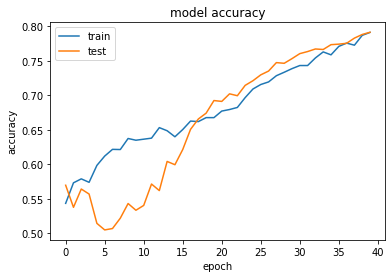

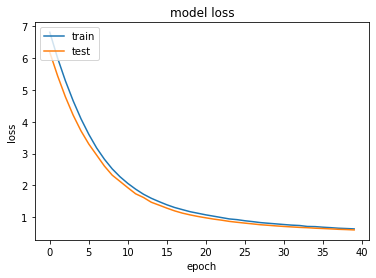

4000/4000 [==============================] - 0s 75us/step
Training Accuracy is 83.92500281333923
4000/4000 [==============================] - 0s 75us/step
Testing Accuracy is 79.12499904632568 
Accuracy: 0.791250
Precision: 0.797346
Recall: 0.781000
F1 score: 0.789088
[[1603  397]
 [ 438 1562]]


In [35]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense
from keras.constraints import max_norm
from keras.regularizers import l1,l2
from keras import optimizers
import keras
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
maxlen = 100
model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen)
model.add(embedding_layer)
model.add(Dense(32, activity_regularizer=l1(0.001), activation='relu'))
model.add(Dropout(0.4))


model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))


model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))



model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))


model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(512,activation='relu'))

model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=optimizers.adam(lr=.0001), loss='binary_crossentropy', metrics=['acc'])
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
print(model.summary())
history = model.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_test, y_test), callbacks=[es_callback])


import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
loss, accuracy = model.evaluate(X_train, y_train, verbose=1)
print('Training Accuracy is {}'.format(accuracy*100))

loss, accuracy = model.evaluate(X_test,y_test)


print('Testing Accuracy is {} '.format(accuracy*100))


yhat_classes = model.predict_classes(X_test)


accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

In [42]:
import numpy as np
class load_file:
    def __init__(self, file):
        self.file = file

    def get_data(self):
        hal = np.load(self.file)
        X_train, y_train, X_test, y_test,vocab_size, embedding_matrix = [hal[f] for f in hal.files]
        return X_train, y_train, X_test, y_test,vocab_size, embedding_matrix


df = load_file('ObamaSplitData.npz')
X_train, y_train, X_test, y_test,vocab_size, embedding_matrix = df.get_data()

loss, accuracy = model.evaluate(X_train, y_train, verbose=1)
print('Training Accuracy is {}'.format(accuracy*100))

loss, accuracy = model.evaluate(X_test,y_test)


print('Testing Accuracy is {} '.format(accuracy*100))

4000/4000 [==============================] - 0s 74us/step
Training Accuracy is 83.92500281333923
4000/4000 [==============================] - 0s 79us/step
Testing Accuracy is 79.12499904632568 


In [44]:
model.save("ObamaModel.h5")
print("Saved model to disk")

Saved model to disk


In [39]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1603  397]
 [ 438 1562]]


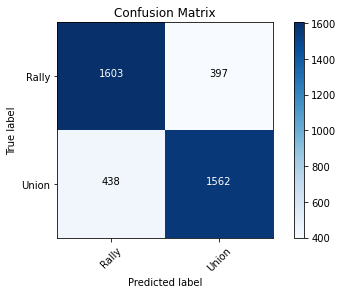

In [40]:
cm =confusion_matrix(y_test, yhat_classes)
labels = ['Rally', 'Union']
plot_confusion_matrix(cm, labels, title='Confusion Matrix')